In [81]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, ParameterGrid
from sklearn.decomposition import PCA

import lightgbm as lgbm

from imblearn.over_sampling import SMOTE

from IPython.display import display

In [245]:
df = pd.read_csv('data/train_final.csv', index_col='Id')

X = df.drop('Y', axis='columns').values
y = df['Y'].values

scale_pos_weight = len(y[y == 0])/len(y[y == 1])

In [242]:
df_ult = pd.read_csv('data/test_final.csv', index_col='Id')

X_ult = df_ult.values

In [5]:
df.drop('Y', axis='columns').describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04,16383.000000
mean,43007.775865,1.044375,11.770938,118323.581456,1.044436,0.050052,117089.674113,169730.178600,1.041812,4.976317,...,25894.316914,119045.099005,184622.040835,1.047305,125959.667765,1.044558,1.045718,1.041934,3.271890e+04,1.043948
std,33611.182771,0.264806,353.187115,4518.059755,0.265601,0.293892,10261.292970,69396.677853,0.258226,65.629620,...,36086.993946,18321.987129,100590.811845,0.306239,31091.344158,0.262576,0.266874,0.246597,3.184929e+06,0.259640
min,-1.000000,1.000000,1.770000,23779.000000,1.000000,0.000000,4292.000000,4673.000000,1.000000,0.000000,...,25.000000,4674.000000,3130.000000,1.000000,117879.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
25%,20311.000000,1.000000,1.770000,118096.000000,1.000000,0.000000,117961.000000,117906.000000,1.000000,0.000000,...,4554.000000,118395.000000,118398.000000,1.000000,118274.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
50%,35527.000000,1.000000,1.770000,118300.000000,1.000000,0.000000,117961.000000,128130.000000,1.000000,0.000000,...,13234.000000,118929.000000,119095.000000,1.000000,118568.000000,1.000000,1.000000,1.000000,2.000000e+00,1.000000
75%,74240.500000,1.000000,3.540000,118386.000000,1.000000,0.000000,117961.000000,234498.500000,1.000000,1.000000,...,38902.000000,120539.000000,290919.000000,1.000000,120006.000000,1.000000,1.000000,1.000000,9.000000e+00,1.000000
max,312152.000000,7.000000,43910.160000,286791.000000,9.000000,10.000000,311178.000000,311867.000000,11.000000,5036.000000,...,311696.000000,286792.000000,308574.000000,18.000000,311867.000000,8.000000,8.000000,7.000000,4.042886e+08,8.000000


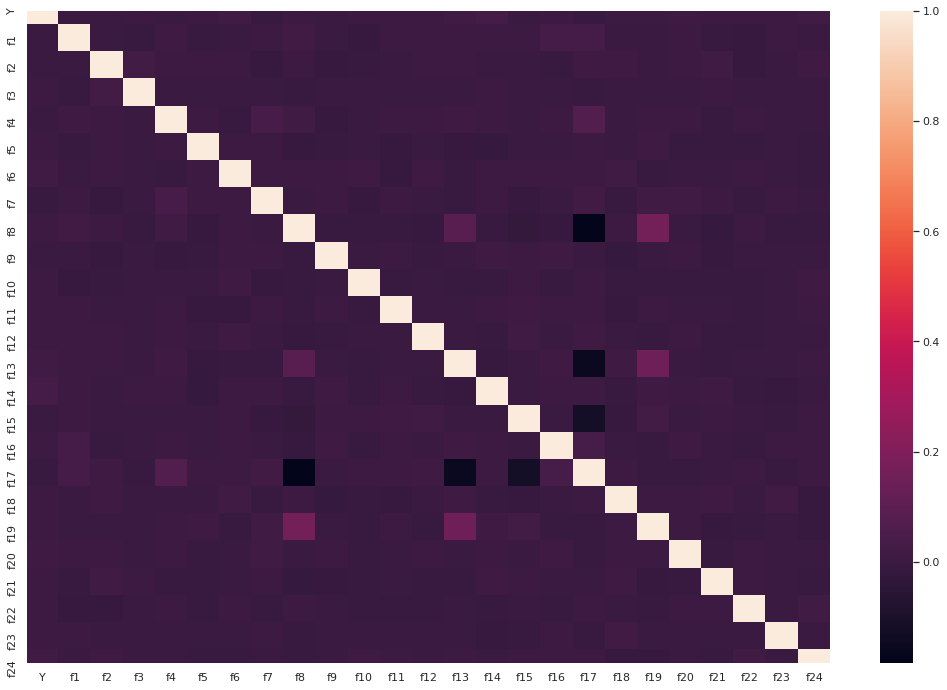

In [6]:
sns.set()
sns.set(rc={'figure.figsize':(18,12)})
sns.heatmap(df.corr());

In [231]:
def get_ind(mask): return [index for index, mask_ele in enumerate(mask) if mask_ele==True]

def get_best_ind(importances, start=7, number=5):
    ranked_features = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
    return [ranked_features[:i] for i in range(start, start + number)]

def get_best_features(model, data, step=1):
    rfecv = RFECV(estimator=model, step=step, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
    return rfecv.fit(data, y)

def get_clf():
    return lgbm.LGBMClassifier(**fix_param, **var_param, **fake_param)

fix_param = {
#     'boosting_type':                 'goss', 
    'metric':                        'auc',
#     'max_depth':                     5, 
    'objective':                     'binary',
#     'scale_pos_weight':              'balanced',
    'scale_pos_weight':              scale_pos_weight,
    'n_jobs':                        -1
}

var_param = {'min_child_samples':             20,
             'learning_rate':                 0.1, 
#              'num_leaves':                    33,
             'reg_alpha':                     0.000659,
             'reg_lambda':                    0.9}

fake_param = {
    'n_estimators':                  900,
    'min_child_weight':              1e-4, 
    'feature_fraction':              0.9,
}

In [246]:
df_copy1 = df_ult.copy()
df_copy1['f8-f19'] = df_ult['f8'] - df_ult['f19'] # iffy
df_copy1['f8-f13'] = df_ult['f8'] - df_ult['f13'] # iffy again
df_copy1['f17-f4'] = df_ult['f17'] - df_ult['f4'] # iffy yet again
df_copy1['f4-f7'] = df_ult['f4'] - df_ult['f7'] # nice
df_copy1['f13-f19'] = df_ult['f13'] - df_ult['f19'] # nice
df_copy1['f8wf13wf19'] = PCA(n_components=1).fit_transform(df_ult[['f8', 'f13', 'f19']])

In [9]:
ranker = get_best_features(get_clf(), X)
def ind_to_name(df, idx): return df.columns[idx].tolist()
best_indices = get_ind(np.isin(ranker.ranking_, [1, 2, 3, 4]))
print(ind_to_name(X_df, best_indices))

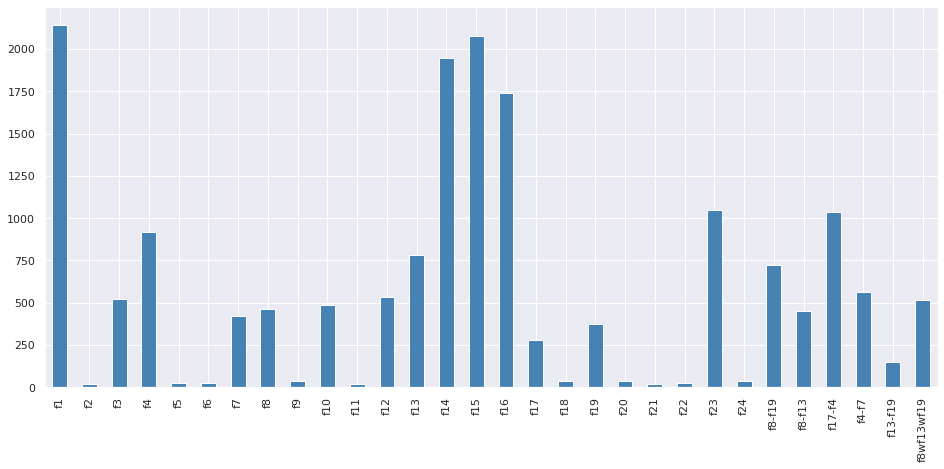

In [10]:
(pd.Series(get_clf().fit(X, y).feature_importances_, index=X_df.columns.tolist())
 .plot.bar(color='steelblue', figsize=(16, 7)));

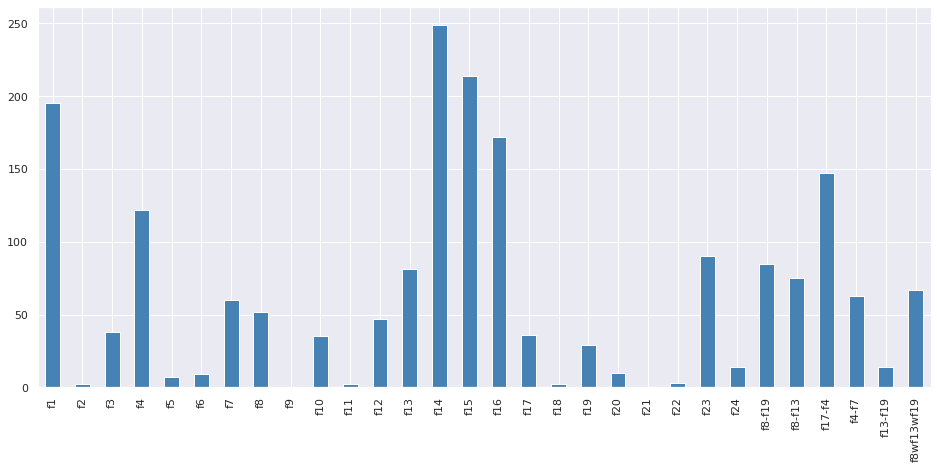

In [11]:
(pd.Series(lgbm.LGBMClassifier(**fix_param).fit(X, y).feature_importances_, 
           index=X_df.columns.tolist())
 .plot.bar(color='steelblue', figsize=(16, 7)));

In [122]:
primary = ([], 0)
for _ in range(24):
    best_feature_score = (0, 0)
    remaining_features = np.setdiff1d(list(range(24)), primary[0]).tolist()
    for current_feature in remaining_features:
        current_features = primary[0] + [current_feature]
        current_score = scorer(current_features)
        if current_score > best_feature_score[1]:
            best_feature_score = (current_feature, current_score)
    if best_feature_score[1] > primary[1]:
        primary = (primary[0] + [best_feature_score[0]], best_feature_score[1])
        print(primary)
    else:
        break

print('done')
print(primary[1])
print(primary[0])

([13], 0.763290477328735)
([13, 12], 0.8106861675422959)
([13, 12, 14], 0.850562583838032)
([13, 12, 14, 3], 0.8726172394324975)
([13, 12, 14, 3, 7], 0.8854984023535192)
([13, 12, 14, 3, 7, 18], 0.8882206423683853)
([13, 12, 14, 3, 7, 18, 15], 0.890757552840429)
done
0.890757552840429
[13, 12, 14, 3, 7, 18, 15]


In [130]:
primary = ([], 0)
for _ in range(30):
    best_feature_score = (0, 0)
    remaining_features = np.setdiff1d(list(range(30)), primary[0]).tolist()
    for current_feature in remaining_features:
        current_features = primary[0] + [current_feature]
        current_score = scorer(current_features)
        if current_score > best_feature_score[1]:
            best_feature_score = (current_feature, current_score)
    if best_feature_score[1] > primary[1]:
        primary = (primary[0] + [best_feature_score[0]], best_feature_score[1])
        print(primary)
    else:
        break

print('done')
print(primary[1])
print(primary[0])

([13], 0.763290477328735)
([13, 12], 0.8106861675422959)
([13, 12, 14], 0.850562583838032)
([13, 12, 14, 3], 0.8726172394324975)
([13, 12, 14, 3, 29], 0.8874161223703495)
([13, 12, 14, 3, 29, 27], 0.8920423988750297)
done
0.8920423988750297
[13, 12, 14, 3, 29, 27]


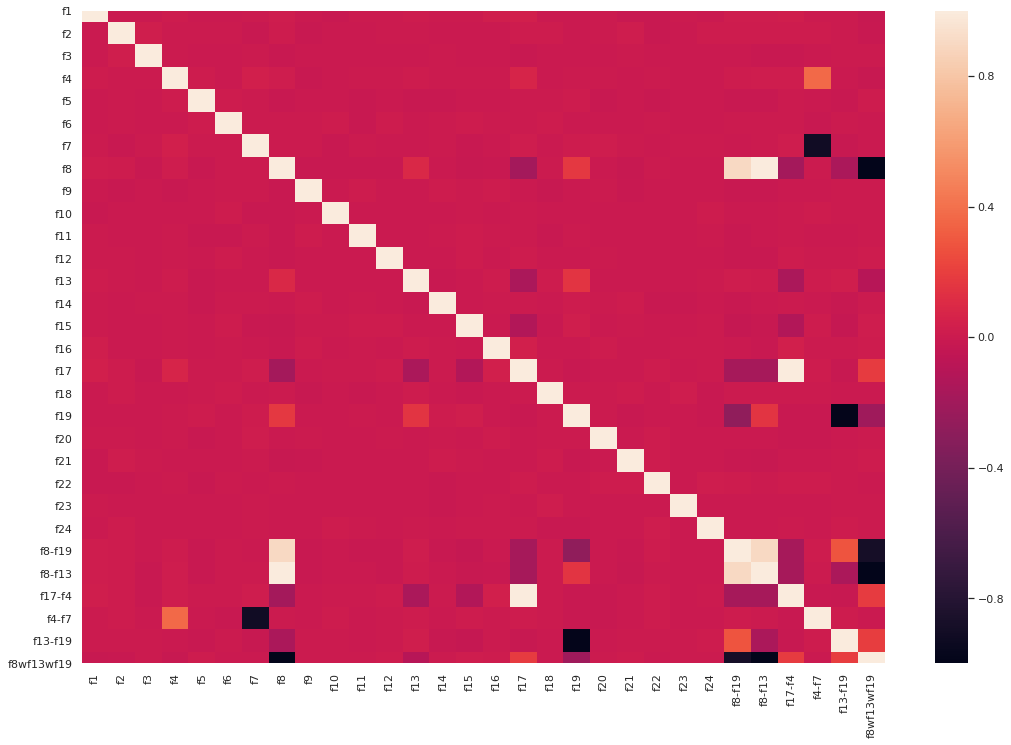

In [12]:
sns.heatmap(X_df.corr());

In [204]:
df_copy[['f8-f19', 'f8-f13']][100:200]

,f8-f19,f8-f13
Id,,
101,-1724,-1725
102,-415,-416
103,1,-2
104,1,-2
105,32472,32470
...,...,...
196,30942,30939
197,0,161706
198,122199,122197


In [13]:
def name_to_ind(df, ind): return list(map(df.columns.tolist().index, ind))

In [27]:
def tuner(tun_param, feats):
    return GridSearchCV(lgbm.LGBMClassifier(**fix_param, **var_param), 
                        tun_param, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1).fit(X_df[feats].values, y)

def scorer(feats):
    grid = tuner(tun_param, feats)
    return round(grid.best_score_, 5)

In [18]:
scorer(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f1', 'f16', 'f17-f4'])

0.89808

In [20]:
def feature_selector(X_df):
    primary = (veteran_cols, 0)
    cols = np.setdiff1d(X_df.columns.tolist(), ignored_cols).tolist()
    for _ in range(len(cols) - len(veteran_cols)):
        best_feature_score = (0, 0)
        remaining_features = np.setdiff1d(cols, primary[0]).tolist()
        for current_feature in remaining_features:
            current_features = primary[0] + [current_feature]
            current_score = scorer(current_features)
            if current_score > best_feature_score[1]:
                best_feature_score = (current_feature, current_score)
        if best_feature_score[1] > primary[1]:
            primary = (primary[0] + [best_feature_score[0]], best_feature_score[1])
            print(primary)
        else:
            break

    print('done')
    print(primary)

In [45]:
feature_selector(X_df)

(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19'], 0.8871028267695898)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7'], 0.8906959590691969)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16'], 0.8916971134248703)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17'], 0.8929468625620874)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19'], 0.8959542967866547)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19', 'f1'], 0.8963335416038576)
(['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19', 'f1', 'f8-f19'], 0.8983396513566012)
done
0.8983396513566012
['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19', 'f1', 'f8-f19']


In [ ]:
outcome_cols = [
    [0, 1, 3, 6, 7, 12, 13, 14, 15, 16, 18, 23], # old best
    [13, 12, 14, 3, 7, 18, 15], # with originals
    [13, 12, 14, 3, 29, 27], # with new
    ['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f1', 'f16', 'f17-f4'], # 0.89808
    ['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19', 'f1', 'f8-f19'] # 0.89834
]

In [55]:
selected_cols = ['f14', 'f13', 'f15', 'f4', 'f8wf13wf19', 'f4-f7', 'f16', 'f17', 'f19', 'f1', 'f8-f19']

tun_param = {
    'n_estimators':                  [880, 950],
    'min_child_weight':              [1e-7], 
    'feature_fraction':              [0.1, 0.4],
}

best_params = []
for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True).split(X_df[selected_cols].values, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
#     X_train, y_train = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)
    best_param = ({}, 0)
    for param_set in ParameterGrid(tun_param):
        model = lgbm.LGBMClassifier(**fix_param, **var_param, **param_set).fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_score)
        if score > best_param[1]:
            best_param = (param_set, score)
    print(best_param)
    best_params.append([frozenset(best_param[0].values()), score])

({'feature_fraction': 0.1, 'min_child_weight': 1e-07, 'n_estimators': 880}, 0.8735341755749919)
({'feature_fraction': 0.4, 'min_child_weight': 1e-07, 'n_estimators': 950}, 0.8787802840434418)
({'feature_fraction': 0.1, 'min_child_weight': 1e-07, 'n_estimators': 880}, 0.8920089338993742)
({'feature_fraction': 0.1, 'min_child_weight': 1e-07, 'n_estimators': 880}, 0.870463781380529)
({'feature_fraction': 0.1, 'min_child_weight': 1e-07, 'n_estimators': 950}, 0.8973695802332018)


In [239]:
now_param = [{
    'boosting_type':                 ['gbdt'],
    'n_estimators':                  [933], 
    'min_child_weight':              [1e-9], 
    'min_split_gain':                [6e-6], 
    'colsample_bytree':              [0.01],
    'num_leaves':                    [28],
    'max_depth':                     [6],
    'pos_bagging_fraction':          [0.5],
    'neg_bagging_fraction':          [0.9],
    'subsample_freq':                [2],
    'subsample':                     [1e-3],
    'seed':                          list(range(40, 50))
}]

def do_tune(tun_param, feats, data=None):
    data = data or X_df[feats].values
    grid = GridSearchCV(lgbm.LGBMClassifier(**fix_param, **var_param), 
                        tun_param, 
                        cv=StratifiedKFold(5), 
                        scoring='roc_auc', 
                        n_jobs=-1)
    
    grid.fit(data, y)
    
    print(f'Best parameters {grid.best_params_}.')
    print(f'Best auc score is {grid.best_score_}.')
    
    clfs.append(grid.best_estimator_)

do_tune(now_param, selected_cols)

Best parameters {'boosting_type': 'gbdt', 'colsample_bytree': 0.01, 'max_depth': 6, 'min_child_weight': 1e-09, 'min_split_gain': 6e-06, 'n_estimators': 933, 'neg_bagging_fraction': 0.9, 'num_leaves': 28, 'pos_bagging_fraction': 0.5, 'seed': 49, 'subsample': 0.001, 'subsample_freq': 2}.
Best auc score is 0.8999725150718494.


In [251]:
req_rows = 16384
sealed_feats = []

display('Re-training...')
preds_dfs = []
sealed_feats = [selected_cols, selected_cols, selected_cols, selected_cols, selected_cols]
for feats, clf in zip(sealed_feats, clfs):
    clf.fit(X_df[feats].values, y)
    preds_dfs.append(pd.DataFrame(clf.predict_proba(df_copy1[feats].values)[:, 1], 
                          index=list(range(req_rows, req_rows*2 + 1)), 
                          columns=['Y']))

display('Writing...')
for idx, df in enumerate(preds_dfs):
    df.index.name = 'Id'
    df.to_csv(f'submission_26_{idx}.csv', float_format='%.15f')
display('Done.')

'Re-training...'

'Writing...'

'Done.'

In [184]:
clfs[0].fit(X_df[selected_cols].values, y)
X_train, X_test, y_train, y_test = train_test_split(X_df[selected_cols].values, y, test_size=0.2)
clfs[0].fit(X_train, y_train)
roc_auc_score(y_test, clfs[0].predict_proba(X_test)[:, 1])

0.8907978906607903